In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove6b100dtxt/glove.6B.100d.txt
/kaggle/input/question-pair/train.csv


In [2]:
#necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


In [3]:
# Load the Dataset
import chardet
file_path = "/kaggle/input/question-pair/train.csv"


# Detect encoding 
with open(file_path, 'rb') as f:
    raw_data = f.read(100000)  
    result = chardet.detect(raw_data)
encoding = result['encoding']


# Read CSV in chunks to handle large dataset
chunksize = 50000
chunks = []

for chunk in pd.read_csv(
    file_path,
    encoding=encoding,       
    chunksize=chunksize,
    on_bad_lines='skip'  
):
    chunks.append(chunk)


# Combine chunks into a single DataFrame
train_df = pd.concat(chunks, ignore_index=True)
print("Dataset loaded successfully")
print("Shape of dataset:", train_df.shape)  

print("\nColumn names:")
print(train_df.columns)  

print("\nFirst 5 rows:")
print(train_df.head())  


Dataset loaded successfully
Shape of dataset: (404347, 6)

Column names:
Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

First 5 rows:
   id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt 

# Exploratory Data Analysis (EDA)

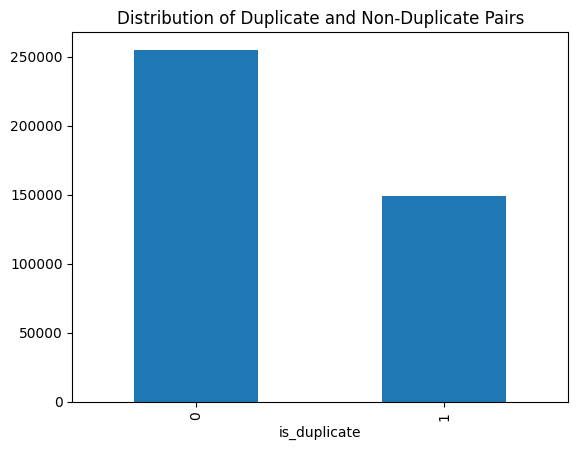

In [4]:
# Check class distribution
train_df['is_duplicate'].value_counts().plot(kind='bar')
plt.title('Distribution of Duplicate and Non-Duplicate Pairs')
plt.show()


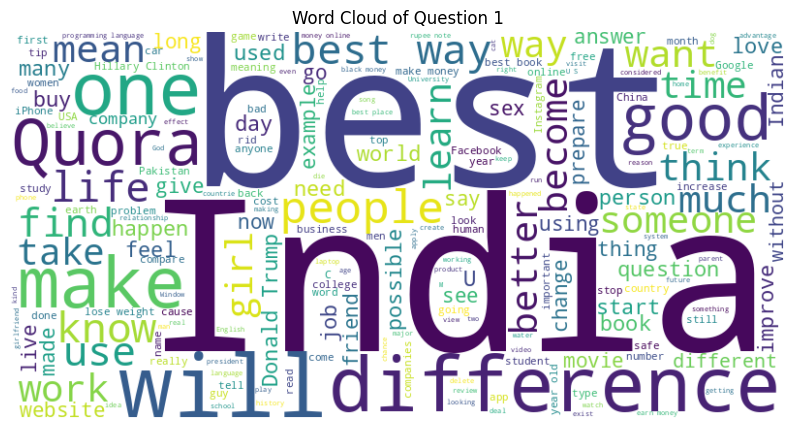

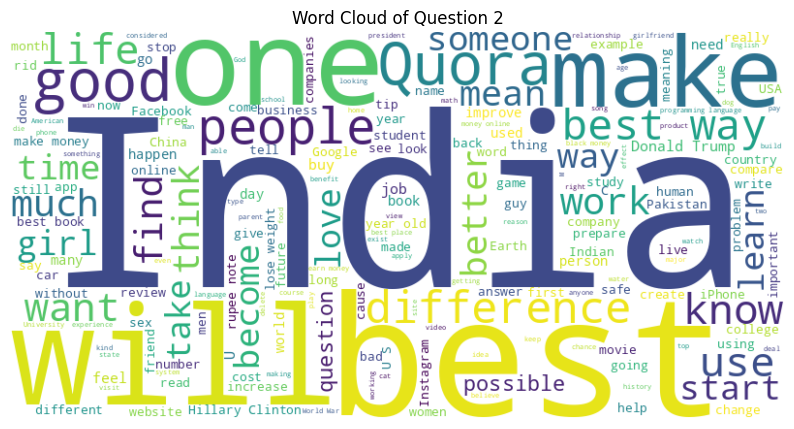

In [5]:
#Wordcloud

from wordcloud import WordCloud

# Combine all questions
all_q1_text = ' '.join(train_df['question1'].astype(str))
all_q2_text = ' '.join(train_df['question2'].astype(str))

# WordCloud for Question 1
plt.figure(figsize=(10,6))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_q1_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Question 1')
plt.show()

# WordCloud for Question 2
plt.figure(figsize=(10,6))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_q2_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Question 2')
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


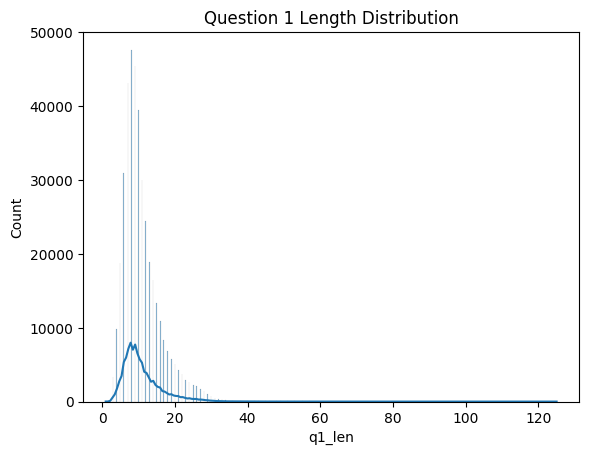

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


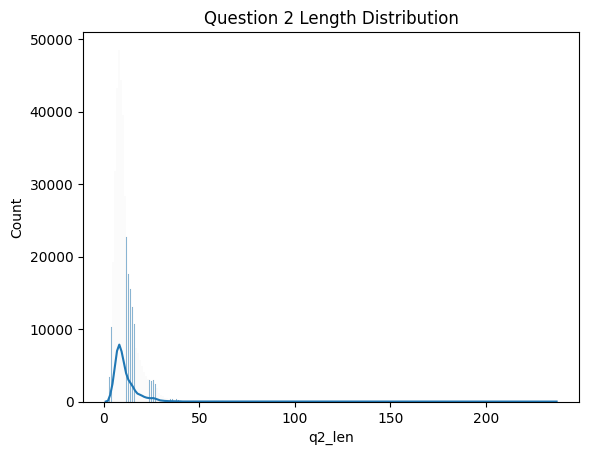

In [6]:
# Sentence length analysis

train_df['q1_len'] = train_df['question1'].apply(lambda x: len(str(x).split()))
train_df['q2_len'] = train_df['question2'].apply(lambda x: len(str(x).split()))

sns.histplot(train_df['q1_len'], kde=True)
plt.title('Question 1 Length Distribution')
plt.show()

sns.histplot(train_df['q2_len'], kde=True)
plt.title('Question 2 Length Distribution')
plt.show()

Top 20 common words in all questions:
the: 371845
What: 292768
is: 216210
I: 211583
a: 208437
to: 203423
How: 201486
in: 190037
of: 158604
do: 139510
are: 134890
and: 130776
for: 100498
can: 87896
you: 84282
Why: 69620
best: 69081
my: 66132
on: 58523
it: 58352


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


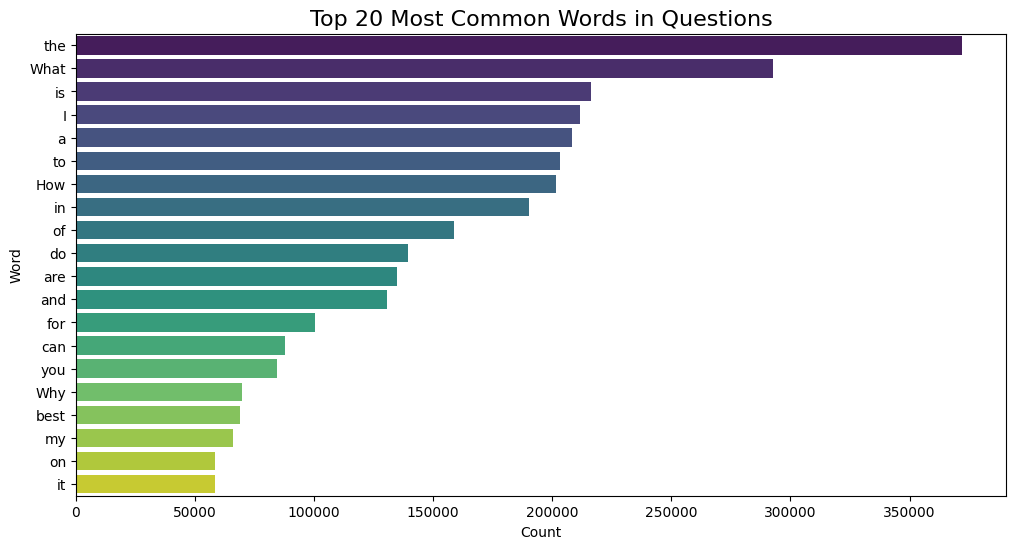

In [7]:
# Most Commom Words Analysis

from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Combine all questions into one text
all_questions = pd.concat([train_df['question1'], train_df['question2']])

# Convert all entries to string and drop missing values
all_questions = all_questions.fillna('').astype(str)

# Tokenize words
all_words = ' '.join(all_questions).split()

# Count most common words
common_words = Counter(all_words).most_common(20)
print("Top 20 common words in all questions:")
for word, count in common_words:
    print(f"{word}: {count}")

# Plot
words, counts = zip(*common_words)
plt.figure(figsize=(12,6))
sns.barplot(x=list(counts), y=list(words), palette='viridis')
plt.title('Top 20 Most Common Words in Questions', fontsize=16)
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()


In [8]:
# Cheak missing values

print(train_df.isnull().sum())

# Handeling Missing Values
train_df['question1'] = train_df['question1'].fillna('').astype(str)
train_df['question2'] = train_df['question2'].fillna('').astype(str)

# Count words in each question
train_df['q1_word_count'] = train_df['question1'].apply(lambda x: len(x.split()))
train_df['q2_word_count'] = train_df['question2'].apply(lambda x: len(x.split()))


id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
q1_len          0
q2_len          0
dtype: int64


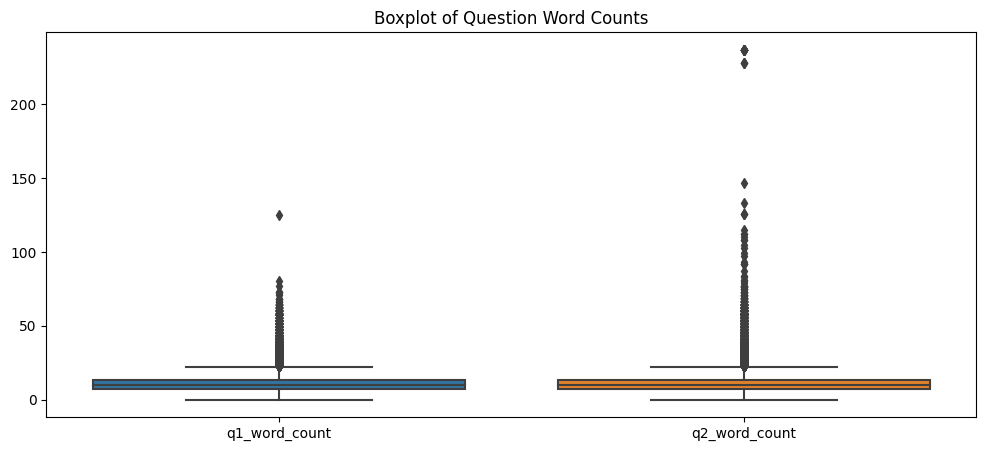

In [9]:
# Outlier Analysis

plt.figure(figsize=(12,5))
sns.boxplot(data=train_df[['q1_word_count','q2_word_count']])
plt.title('Boxplot of Question Word Counts')
plt.show()

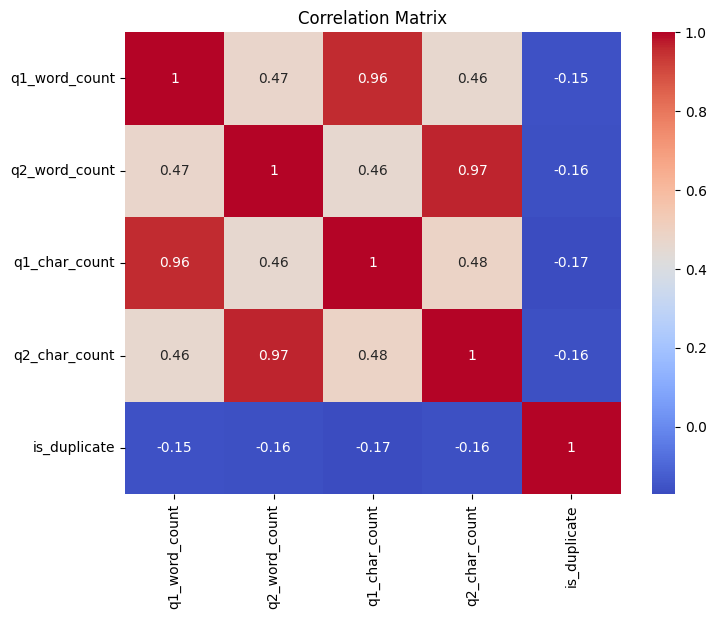

In [10]:
# Correlation

# Ensure questions are strings
train_df['question1'] = train_df['question1'].fillna('').astype(str)
train_df['question2'] = train_df['question2'].fillna('').astype(str)

# Count characters in each question
train_df['q1_char_count'] = train_df['question1'].apply(len)
train_df['q2_char_count'] = train_df['question2'].apply(len)

#Corelation plot
corr_df = train_df[['q1_word_count','q2_word_count','q1_char_count','q2_char_count','is_duplicate']]
plt.figure(figsize=(8,6))
sns.heatmap(corr_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()



# **Text Preprocessing**

In [11]:
#Basic Cleaning
import re 

def clean_text(text):
    text = str(text).lower()                       # Lowercasing
    text = re.sub(r"[^a-z\s]", "", text)          # Removes special characters,unnecessary punctuation
    text = re.sub(r"\s+", " ", text).strip()      # Remove extra spaces
    return text

train_df['question1_clean'] = train_df['question1'].apply(clean_text)
train_df['question2_clean'] = train_df['question2'].apply(clean_text)


train_df[['question1', 'question1_clean', 'question2', 'question2_clean']].head()

,question1,question1_clean,question2,question2_clean
0,What is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,what is the story of kohinoor kohinoor diamond,What would happen if the Indian government sto...,what would happen if the indian government sto...
2,How can I increase the speed of my internet co...,how can i increase the speed of my internet co...,How can Internet speed be increased by hacking...,how can internet speed be increased by hacking...
3,Why am I mentally very lonely? How can I solve...,why am i mentally very lonely how can i solve it,Find the remainder when [math]23^{24}[/math] i...,find the remainder when mathmath is divided by
4,"Which one dissolve in water quikly sugar, salt...",which one dissolve in water quikly sugar salt ...,Which fish would survive in salt water?,which fish would survive in salt water


In [12]:
#Tokenization

# Tokenize each question into a list of words
train_df['question1_tokens'] = train_df['question1_clean'].apply(lambda x: x.split())
train_df['question2_tokens'] = train_df['question2_clean'].apply(lambda x: x.split())

train_df[['question1_clean', 'question1_tokens']].head()
train_df[['question2_clean', 'question2_tokens']].head()

,question2_clean,question2_tokens
0,what is the step by step guide to invest in sh...,"[what, is, the, step, by, step, guide, to, inv..."
1,what would happen if the indian government sto...,"[what, would, happen, if, the, indian, governm..."
2,how can internet speed be increased by hacking...,"[how, can, internet, speed, be, increased, by,..."
3,find the remainder when mathmath is divided by,"[find, the, remainder, when, mathmath, is, div..."
4,which fish would survive in salt water,"[which, fish, would, survive, in, salt, water]"


In [13]:
# Removing stopwords

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords') 

# Set of English stopwords
stop_words = set(stopwords.words('english'))

# Remove stopwords
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

# Apply
train_df['question1_clean'] = train_df['question1_clean'].apply(remove_stopwords)
train_df['question2_clean'] = train_df['question2_clean'].apply(remove_stopwords)


train_df[['question1', 'question1_clean', 'question2', 'question2_clean']].head()


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,question1,question1_clean,question2,question2_clean
0,What is the step by step guide to invest in sh...,step step guide invest share market india,What is the step by step guide to invest in sh...,step step guide invest share market
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,story kohinoor kohinoor diamond,What would happen if the Indian government sto...,would happen indian government stole kohinoor ...
2,How can I increase the speed of my internet co...,increase speed internet connection using vpn,How can Internet speed be increased by hacking...,internet speed increased hacking dns
3,Why am I mentally very lonely? How can I solve...,mentally lonely solve,Find the remainder when [math]23^{24}[/math] i...,find remainder mathmath divided
4,"Which one dissolve in water quikly sugar, salt...",one dissolve water quikly sugar salt methane c...,Which fish would survive in salt water?,fish would survive salt water


In [14]:
# Lemitization 

import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4') 

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

train_df['question1_clean'] = train_df['question1_clean'].apply(lemmatize_text)
train_df['question2_clean'] = train_df['question2_clean'].apply(lemmatize_text)

train_df[['question1', 'question1_clean', 'question2', 'question2_clean']].head(10)



[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


,question1,question1_clean,question2,question2_clean
0,What is the step by step guide to invest in sh...,step step guide invest share market india,What is the step by step guide to invest in sh...,step step guide invest share market
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,story kohinoor kohinoor diamond,What would happen if the Indian government sto...,would happen indian government stole kohinoor ...
2,How can I increase the speed of my internet co...,increase speed internet connection using vpn,How can Internet speed be increased by hacking...,internet speed increased hacking dns
3,Why am I mentally very lonely? How can I solve...,mentally lonely solve,Find the remainder when [math]23^{24}[/math] i...,find remainder mathmath divided
4,"Which one dissolve in water quikly sugar, salt...",one dissolve water quikly sugar salt methane c...,Which fish would survive in salt water?,fish would survive salt water
5,Astrology: I am a Capricorn Sun Cap moon and c...,astrology capricorn sun cap moon cap risingwha...,"I'm a triple Capricorn (Sun, Moon and ascendan...",im triple capricorn sun moon ascendant caprico...
6,Should I buy tiago?,buy tiago,What keeps childern active and far from phone ...,keep childern active far phone video game
7,How can I be a good geologist?,good geologist,What should I do to be a great geologist?,great geologist
8,When do you use · instead of W?,use instead w,"When do you use ""&"" instead of ""and""?",use instead
9,Motorola (company): Can I hack my Charter Moto...,motorola company hack charter motorolla dcx,How do I hack Motorola DCX3400 for free internet?,hack motorola dcx free internet


In [15]:
# Feature Extraction

# TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer

# Combine all questions
all_questions = pd.concat([train_df['question1_clean'], train_df['question2_clean']])

# Apply TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
tfidf.fit(all_questions)

# Transform Q1 and Q2
q1_tfidf = tfidf.transform(train_df['question1_clean'])
q2_tfidf = tfidf.transform(train_df['question2_clean'])

print("TF-IDF shapes:", q1_tfidf.shape, q2_tfidf.shape)


TF-IDF shapes: (404347, 5000) (404347, 5000)


In [16]:
#Glove Embeddings

# Load GloVe
glove_path = "/kaggle/input/glove6b100dtxt/glove.6B.100d.txt"
embedding_index = {}
with open(glove_path, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        embedding_index[word] = vector

print("Loaded GloVe vectors:", len(embedding_index))

# Average word vectors
def glove_sentence_vec(text, embedding_index, embedding_dim=100):
    words = text.split()
    vectors = [embedding_index[w] for w in words if w in embedding_index]
    if len(vectors) == 0:
        return np.zeros(embedding_dim)
    else:
        return np.mean(vectors, axis=0)

# Apply to questions
q1_glove = np.array([glove_sentence_vec(q, embedding_index) for q in train_df['question1_clean']])
q2_glove = np.array([glove_sentence_vec(q, embedding_index) for q in train_df['question2_clean']])

print("GloVe shapes:", q1_glove.shape, q2_glove.shape)


Loaded GloVe vectors: 400000
GloVe shapes: (404347, 100) (404347, 100)


In [17]:
#Hybrid Approch (TF-IDF features with GloVe embeddings)

from scipy.sparse import hstack

# Convert GloVe arrays to sparse for stacking
from scipy.sparse import csr_matrix

q1_hybrid = hstack([q1_tfidf, csr_matrix(q1_glove)])
q2_hybrid = hstack([q2_tfidf, csr_matrix(q2_glove)])

print("Hybrid shapes:", q1_hybrid.shape, q2_hybrid.shape)


Hybrid shapes: (404347, 5100) (404347, 5100)


# **Model Creation & Evaluation**

# Logistic Regression

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.87      0.81     51009
           1       0.69      0.51      0.59     29861

    accuracy                           0.74     80870
   macro avg       0.72      0.69      0.70     80870
weighted avg       0.73      0.74      0.73     80870



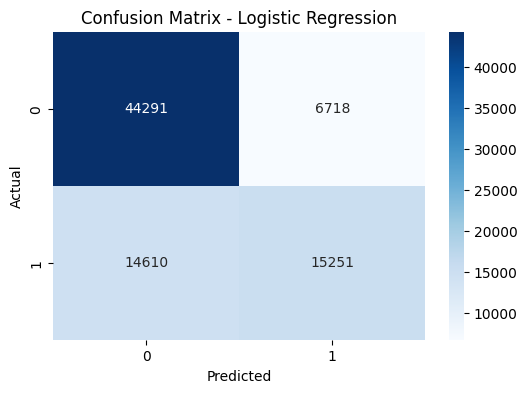

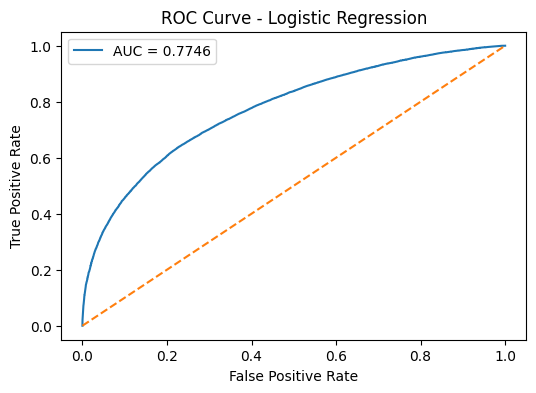

In [19]:
# Logistic Regression on TF-IDF features

import pandas as pd
import numpy as np
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns


# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')

q1_tfidf = tfidf.fit_transform(train_df['question1_clean'])
q2_tfidf = tfidf.fit_transform(train_df['question2_clean'])


# Hybrid TF-IDF features
X_base = hstack([q1_tfidf, q2_tfidf])
y_base = train_df['is_duplicate'].values


# Train-Test-Split
X_train_base, X_val_base, y_train_base, y_val_base = train_test_split(
    X_base, y_base, test_size=0.2, random_state=42, stratify=y_base
)


#Train
lr = LogisticRegression(max_iter=500)
lr.fit(X_train_base, y_train_base)



# Evaluation Matrics

# Predictions & class probabilities
y_pred_base = lr.predict(X_val_base)
y_prob_base = lr.predict_proba(X_val_base)[:, 1]

# Individual metrics
accuracy = accuracy_score(y_val_base, y_pred_base)
precision = precision_score(y_val_base, y_pred_base)
recall = recall_score(y_val_base, y_pred_base)
f1 = f1_score(y_val_base, y_pred_base)
auc = roc_auc_score(y_val_base, y_prob_base)

print("Classification Report:\n", classification_report(y_val_base, y_pred_base))
print("===================================================")

# Confusion Matrix
cm = confusion_matrix(y_val_base, y_pred_base)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("===================================================")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_val_base, y_prob_base)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0,1], [0,1], linestyle='--')  
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()



Keras Cheaking to avoid Conflict

In [ ]:
#Keras Cheaking to avoid Conflict
!pip uninstall -y keras


In [ ]:
!pip install tensorflow
!pip install --upgrade protobuf==4.23.3


In [20]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Dropout, Lambda
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

print(tf.__version__) 



2025-11-21 11:29:41.960239: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763724582.246687      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763724582.329069      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

2.18.0


# Siamese + LSTM Model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-11-21 11:30:30.773817: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 20, 100)   │    500,000 │ input_layer[0][0… │
│ (Embedding)         │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128)       │    117,248 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128)       │          0 │ lstm[0][0],       │
│                     │                   │            │ lstm[1][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │        129 │ lambda[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 617,377 (2.36 MB)

 Trainable params: 117,377 (458.50 KB)

 Non-trainable params: 500,000 (1.91 MB)

Epoch 1/3
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 172s 67ms/step - accuracy: 0.7023 - loss: 0.5401 - val_accuracy: 0.7642 - val_loss: 0.4671
Epoch 2/3
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 167s 66ms/step - accuracy: 0.7753 - loss: 0.4492 - val_accuracy: 0.7768 - val_loss: 0.4477
Epoch 3/3
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 166s 66ms/step - accuracy: 0.7949 - loss: 0.4156 - val_accuracy: 0.7828 - val_loss: 0.4374
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step
              precision    recall  f1-score   support

           0       0.84      0.81      0.83     51009
           1       0.70      0.73      0.71     29861

    accuracy                           0.78     80870
   macro avg       0.77      0.77      0.77     80870
weighted avg       0.79      0.78      0.78     80870



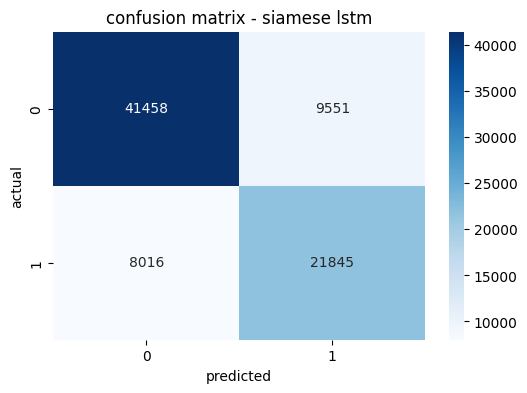

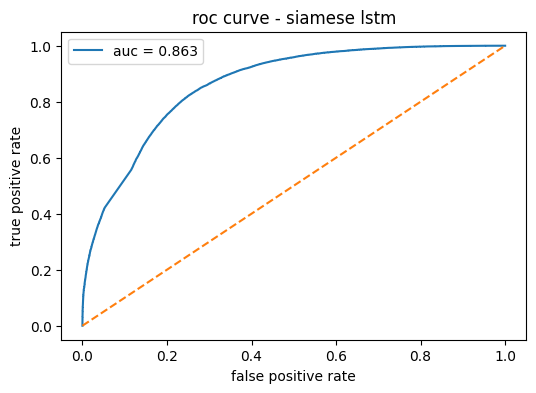

In [21]:
# Siamese LSTM

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Lambda, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

# keras tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(pd.concat([train_df['question1_clean'], train_df['question2_clean']]))

# text to sequences
seq_q1 = tokenizer.texts_to_sequences(train_df['question1_clean'])
seq_q2 = tokenizer.texts_to_sequences(train_df['question2_clean'])

# pad sequences
max_len = 20
seq_q1_pad = pad_sequences(seq_q1, maxlen=max_len)
seq_q2_pad = pad_sequences(seq_q2, maxlen=max_len)
y_seq = train_df['is_duplicate'].values

# train-test split
X1_train, X1_val, X2_train, X2_val, y_train_seq, y_val_seq = train_test_split(
    seq_q1_pad, seq_q2_pad, y_seq, test_size=0.2, random_state=42, stratify=y_seq
)

# glove embedding dimension
embedding_dim = 100

# embedding matrix
vocab_size = min(5000, len(tokenizer.word_index) + 1)
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# loading glove vectors
for word, i in tokenizer.word_index.items():
    if i >= vocab_size:
        continue
    if word in embedding_index:
        embedding_matrix[i] = embedding_index[word]

# define model
def siamese_lstm_model():
    # input layers
    input1 = Input(shape=(max_len,))
    input2 = Input(shape=(max_len,))
    
    # embedding layer
    embedding_layer = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False
    )
    
    # lstm encoder
    lstm = LSTM(128)
    
    # encoding both questions
    encoded1 = lstm(embedding_layer(input1))
    encoded2 = lstm(embedding_layer(input2))
    
    # manhattan distance
    merged = Lambda(lambda x: tf.abs(x[0] - x[1]))([encoded1, encoded2])
    
    # output layer
    output = Dense(1, activation='sigmoid')(merged)
    
    # build model
    model = Model([input1, input2], output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# create model
model_siamese = siamese_lstm_model()
model_siamese.summary()

# train model
history_siamese = model_siamese.fit(
    [X1_train, X2_train], y_train_seq,
    validation_data=([X1_val, X2_val], y_val_seq),
    epochs=3,
    batch_size=128,
    verbose=1
)


# model evaluation 

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns

# predictions
y_pred_prob = model_siamese.predict([X1_val, X2_val])
y_pred = (y_pred_prob > 0.5).astype(int)

# compute metrics
accuracy = accuracy_score(y_val_seq, y_pred)
precision = precision_score(y_val_seq, y_pred)
recall = recall_score(y_val_seq, y_pred)
f1 = f1_score(y_val_seq, y_pred)
auc = roc_auc_score(y_val_seq, y_pred_prob)

print(classification_report(y_val_seq, y_pred))
print("===================================================")

# confusion matrix
cm = confusion_matrix(y_val_seq, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("confusion matrix - siamese lstm")
plt.xlabel("predicted")
plt.ylabel("actual")
plt.show()
print("===================================================")


# ROC curve
fpr, tpr, thresholds = roc_curve(y_val_seq, y_pred_prob)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label="auc = " + str(round(auc, 4)))
plt.plot([0,1], [0,1], linestyle="--")
plt.title("roc curve - siamese lstm")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend()
plt.show()


# ANN Model

In [ ]:
#ANN Model

# libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, classification_report
)
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# hybrid features: tfidf + glove
X_ann = hstack([q1_hybrid, q2_hybrid])
y_ann = train_df['is_duplicate'].values

# train-test split
X_train_ann, X_val_ann, y_train_ann, y_val_ann = train_test_split(
    X_ann, y_ann, test_size=0.2, random_state=42, stratify=y_ann
)

# scale features 
scaler = StandardScaler(with_mean=False)
X_train_ann_scaled = scaler.fit_transform(X_train_ann)
X_val_ann_scaled = scaler.transform(X_val_ann)


# build model

ann_model = Sequential()
ann_model.add(Dense(512, activation='relu', input_shape=(X_train_ann_scaled.shape[1],)))
ann_model.add(Dropout(0.3))
ann_model.add(Dense(256, activation='relu'))
ann_model.add(Dropout(0.3))
ann_model.add(Dense(1, activation='sigmoid'))

ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# train model
ann_history = ann_model.fit(
    X_train_ann_scaled, y_train_ann,
    validation_data=(X_val_ann_scaled, y_val_ann),
    epochs=3,
    batch_size=128,
    verbose=1
)


# Evaluation 

# predictions
y_pred_prob = ann_model.predict(X_val_ann_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

# metrics
accuracy = accuracy_score(y_val_ann, y_pred)
precision = precision_score(y_val_ann, y_pred)
recall = recall_score(y_val_ann, y_pred)
f1 = f1_score(y_val_ann, y_pred)
auc = roc_auc_score(y_val_ann, y_pred_prob)


print("\nclassification report:\n")
print(classification_report(y_val_ann, y_pred))
print("===================================================")


# confusion matrix
cm = confusion_matrix(y_val_ann, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("confusion matrix - ann")
plt.xlabel("predicted")
plt.ylabel("actual")
plt.show()
print("===================================================")


# ROC curve

fpr, tpr, thresholds = roc_curve(y_val_ann, y_pred_prob)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label="auc = " + str(round(auc, 4)))
plt.plot([0,1], [0,1], linestyle="--")
plt.title("roc curve - ann")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend()
plt.show()


# BERT Model

In [ ]:
#BERT Model
!pip install -q transformers tensorflow --upgrade

import tensorflow as tf
from transformers import AutoTokenizer, TFBertModel
from sklearn.model_selection import train_test_split
print("Ready")

In [ ]:
# Data split 
X_q1 = train_df['question1_clean'].astype(str).values
X_q2 = train_df['question2_clean'].astype(str).values
y    = train_df['is_duplicate'].values

X_q1_train, X_q1_val, X_q2_train, X_q2_val, y_train, y_val = train_test_split(
    X_q1, X_q2, y, test_size=0.20, random_state=42, stratify=y
)

print(f"Train: {len(y_train)} | Val: {len(y_val)}")

In [ ]:
# BERT 

MODEL_NAME = "bert-base-uncased"

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Encode 
def encode(q1, q2):
    enc = tokenizer(list(q1), list(q2),
                    max_length=100,
                    padding='max_length',
                    truncation=True,
                    return_tensors='tf')        # ← important
    return enc['input_ids'], enc['attention_mask']

train_ids,   train_mask   = encode(X_q1_train, X_q2_train)
val_ids,     val_mask     = encode(X_q1_val,   X_q2_val)


# Model 
class BertForPairs(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.bert = TFBertModel.from_pretrained(MODEL_NAME)
        self.dropout = tf.keras.layers.Dropout(0.3)
        self.classifier = tf.keras.layers.Dense(1, activation='sigmoid')
    
    def call(self, inputs, training=False):
        input_ids, attention_mask = inputs
        bert_out = self.bert(input_ids=input_ids,
                             attention_mask=attention_mask,
                             training=training)
        cls_token = bert_out.last_hidden_state[:, 0, :]   # [CLS]
        x = self.dropout(cls_token, training=training)
        return self.classifier(x)

bert_model = BertForPairs()

bert_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("BERT model created – ready to train!")

In [ ]:
# Train
bert_model.fit(
    [train_ids, train_mask], y_train,
    validation_data=([val_ids, val_mask], y_val),
    epochs=3,
    batch_size=16,
    verbose=1
)

print("BERT training finished!")


#Evaluation

# predictions
y_pred_prob = bert_model.predict([val_ids, val_mask])
y_pred = (y_pred_prob > 0.5).astype(int)

# compute metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_pred_prob)


print(classification_report(y_val, y_pred))
print("===================================================")

# confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("confusion matrix - BERT")
plt.xlabel("predicted")
plt.ylabel("actual")
plt.show()
print("===================================================")

# ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label="auc = " + str(round(auc, 4)))
plt.plot([0,1], [0,1], linestyle="--")
plt.title("roc curve - BERT")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend()
plt.show()

# DistilBERT Model

In [ ]:
# DistilBERT
from transformers import TFDistilBertModel

In [ ]:
#Model

MODEL_NAME = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def encode(q1, q2):
    return tokenizer(
        list(q1), list(q2),
        max_length=100,
        truncation=True,
        padding='max_length',
        return_tensors='tf'
    )

train_ids,   train_mask   = encode(X_q1_train, X_q2_train)['input_ids'], encode(X_q1_train, X_q2_train)['attention_mask']
val_ids,     val_mask     = encode(X_q1_val,   X_q2_val)['input_ids'],   encode(X_q1_val,   X_q2_val)['attention_mask']

class DistilBertForPairs(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.distilbert = TFDistilBertModel.from_pretrained(MODEL_NAME)  # Now recognized
        self.dropout = tf.keras.layers.Dropout(0.3)
        self.classifier = tf.keras.layers.Dense(1, activation='sigmoid')
    
    def call(self, inputs, training=False):
        input_ids, attention_mask = inputs
        out = self.distilbert(input_ids=input_ids,
                              attention_mask=attention_mask,
                              training=training)
        cls_token = out.last_hidden_state[:, 0, :]
        x = self.dropout(cls_token, training=training)
        return self.classifier(x)

distilbert_model = DistilBertForPairs()

distilbert_model.compile(
    optimizer=tf.keras.optimizers.Adam(3e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("DistilBERT model successfully created!")

In [ ]:
distilbert_model.fit(
    [train_ids, train_mask], y_train,
    validation_data=([val_ids, val_mask], y_val),
    epochs=3,
    batch_size=32,
    verbose=1
)
print("DistilBERT training finished!")



# DistilBERT evaluation

# predictions
y_pred_prob = distilbert_model.predict([val_ids, val_mask])
y_pred = (y_pred_prob > 0.5).astype(int)

# compute metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_pred_prob)


print("\nclassification report:\n")
print(classification_report(y_val, y_pred))
print("===================================================")


# confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("confusion matrix - DistilBERT")
plt.xlabel("predicted")
plt.ylabel("actual")
plt.show()
print("===================================================")

# ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label="auc = " + str(round(auc, 4)))
plt.plot([0,1], [0,1], linestyle="--")
plt.title("roc curve - DistilBERT")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend()
plt.show()
